In [2]:
from PIL import Image
from PIL.ExifTags import TAGS, GPSTAGS
import requests
import folium

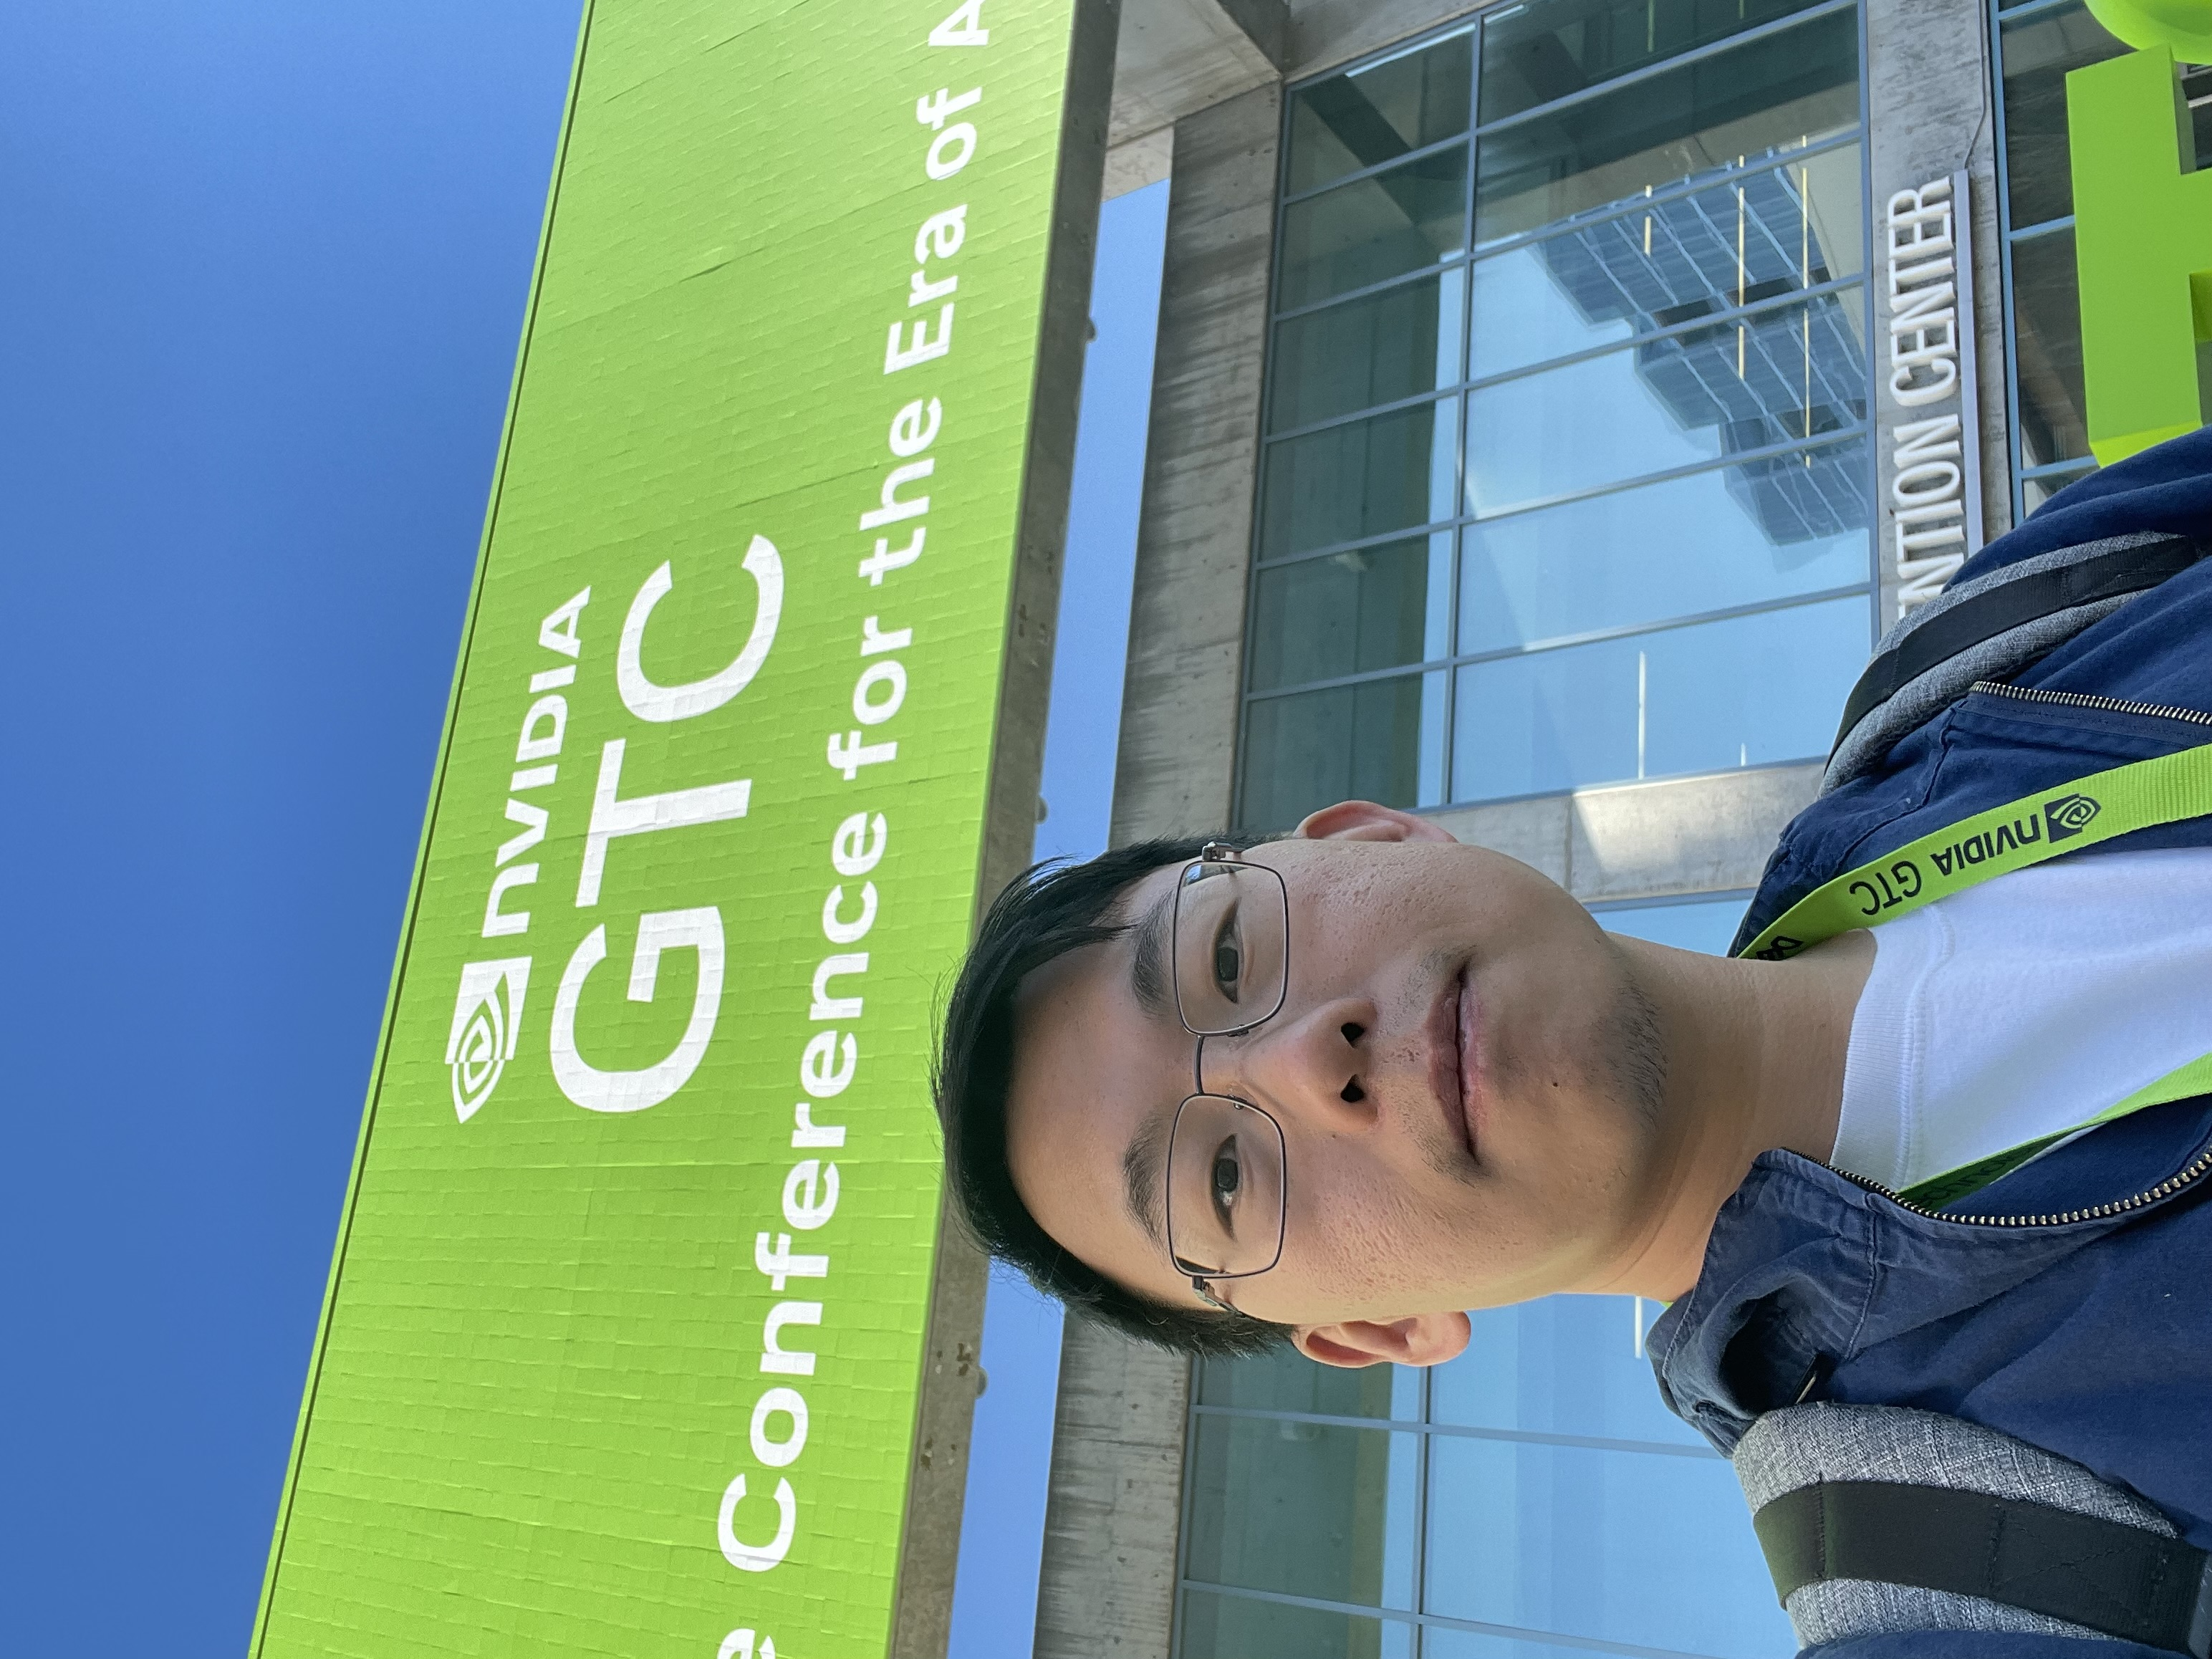

In [25]:
from IPython.display import Image

# Display an image file with specified dimensions
Image(filename='IMG_0803.jpeg', width=300, height=200)  # Adjust these values as needed

In [3]:
def dms_to_decimal(degrees, minutes, seconds, direction):
    """Converts degrees, minutes, and seconds to decimal degrees."""
    decimal = degrees + (minutes / 60.0) + (seconds / 3600.0)
    if direction in ['S', 'W']:
        decimal = -decimal
    return decimal


def get_gps_data(image_path):
    """ Extracts GPS data from a JPEG image file if available. """
    with Image.open(image_path) as img:
        exif_data = img._getexif()
        if not exif_data:
            return "No EXIF metadata found"

        gps_info = {}
        # Check if the GPSInfo tag is present
        gps_tag = {TAGS[key]: val for key, val in exif_data.items() if key in TAGS}
        
        if 'GPSInfo' in gps_tag:
            for key in gps_tag['GPSInfo'].keys():
                decode = GPSTAGS.get(key, key)
                gps_info[decode] = gps_tag['GPSInfo'][key]
            return gps_info
        else:
            return "No GPS data found"

# Example usage
gps_data = get_gps_data('IMG_0803.jpeg')
print(gps_data)

{'GPSLatitudeRef': 'N', 'GPSLatitude': (37.0, 19.0, 48.16), 'GPSLongitudeRef': 'W', 'GPSLongitude': (121.0, 53.0, 20.13), 'GPSAltitudeRef': b'\x00', 'GPSAltitude': 29.69203722854188, 'GPSTimeStamp': (0.0, 32.0, 15.0), 'GPSSpeedRef': 'K', 'GPSSpeed': 0.0, 'GPSImgDirectionRef': 'T', 'GPSImgDirection': 156.23205574912893, 'GPSDestBearingRef': 'T', 'GPSDestBearing': 336.2320557491289, 'GPSDateStamp': '2024:03:18', 'GPSHPositioningError': 14.246706915477498}


In [4]:
latitude = dms_to_decimal(*gps_data['GPSLatitude'], gps_data['GPSLatitudeRef'])
longitude = dms_to_decimal(*gps_data['GPSLongitude'], gps_data['GPSLongitudeRef'])

### Pinpoint Photo using OpenStreetMap

In [5]:
def get_location_by_coordinates(lat, lon):
    """ Returns the location details given latitude and longitude. """
    url = 'https://nominatim.openstreetmap.org/reverse'
    params = {
        'format': 'json',
        'lat': lat,
        'lon': lon,
        'zoom': 18  # Adjust zoom level to your needs
    }
    
    response = requests.get(url, params=params)
    data = response.json()
    
    return data

location_info = get_location_by_coordinates(latitude, longitude)
print(location_info)

{'place_id': 311070409, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 1153917987, 'lat': '37.3301378', 'lon': '-121.88893509359903', 'class': 'leisure', 'type': 'garden', 'place_rank': 30, 'importance': 9.99999999995449e-06, 'addresstype': 'leisure', 'name': '', 'display_name': 'West San Carlos Street, SoFA, San Jose, Santa Clara County, California, 95113, United States', 'address': {'road': 'West San Carlos Street', 'neighbourhood': 'SoFA', 'city': 'San Jose', 'county': 'Santa Clara County', 'state': 'California', 'ISO3166-2-lvl4': 'US-CA', 'postcode': '95113', 'country': 'United States', 'country_code': 'us'}, 'boundingbox': ['37.3300908', '37.3302194', '-121.8889984', '-121.8889130']}


## Pinpoint Photo on Map

In [7]:
def create_map(lat, lon):
    map = folium.Map(location=[lat, lon], zoom_start=15)
    folium.Marker([lat, lon], popup='Your Location').add_to(map)
    return map

map = create_map(latitude, longitude)
map

In [20]:
from IPython.display import Video

Video("IMG_0393.MOV", width=300, height=480)

In [10]:
from hachoir.parser import createParser
from hachoir.metadata import extractMetadata

def get_video_metadata(video_path):
    """ Extracts metadata from a video file. """
    parser = createParser(video_path)
    if not parser:
        print("Unable to create parser for the video.")
        return {}

    with parser:
        metadata = extractMetadata(parser)
        print(metadata)
        if not metadata:
            print("Could not extract metadata.")
            return {}

        # Convert the metadata exportPlaintext output to a readable dictionary
        metadata_dict = {}
        for line in metadata.exportPlaintext():
            if ": " in line:
                key, value = line.split(": ", 1)
                metadata_dict[key.strip()] = value.strip()
        return metadata_dict

video_metadata = get_video_metadata('IMG_0393.MOV')
print(video_metadata)

Metadata:
- Duration: 14 sec 278 ms
- Image width: 1920 pixels
- Image height: 1080 pixels
- Creation date: 2024-04-12 04:10:51
- Last modification: 2024-04-12 04:11:06
- Comment: Play speed: 100.0%
- Comment: User volume: 100.0%
- MIME type: video/quicktime
- Endianness: Big endian
{'- Duration': '14 sec 278 ms', '- Image width': '1920 pixels', '- Image height': '1080 pixels', '- Creation date': '2024-04-12 04:10:51', '- Last modification': '2024-04-12 04:11:06', '- Comment': 'User volume: 100.0%', '- MIME type': 'video/quicktime', '- Endianness': 'Big endian'}


In [13]:
import subprocess
import re

def get_gps_data(video_path):
    command = f'exiftool -gpslatitude -gpslongitude "{video_path}"'
    result = subprocess.run(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    output = result.stdout.decode('utf-8')
    if result.returncode != 0 or not output:
        print("Error or no data available:", result.stderr.decode('utf-8'))
        return None
    
    # Parsing GPS data
    lat_match = re.search(r"GPS Latitude\s+:\s+(\d+) deg (\d+)' ([\d.]+)\" (\w)", output)
    lon_match = re.search(r"GPS Longitude\s+:\s+(\d+) deg (\d+)' ([\d.]+)\" (\w)", output)

    if not lat_match or not lon_match:
        print("GPS data not found.")
        return None

    # Convert DMS to Decimal
    def dms_to_decimal(degrees, minutes, seconds, direction):
        decimal = float(degrees) + float(minutes)/60 + float(seconds)/3600
        if direction in ['S', 'W']:
            decimal = -decimal
        return decimal

    latitude = dms_to_decimal(*lat_match.groups())
    longitude = dms_to_decimal(*lon_match.groups())

    return {
        'Latitude': latitude,
        'Longitude': longitude
    }

video_gps_data = get_gps_data('IMG_0393.MOV')
print(video_gps_data)

{'Latitude': 37.791199999999996, 'Longitude': -122.41300000000001}


In [14]:
location_info = get_location_by_coordinates(video_gps_data['Latitude'], video_gps_data['Longitude'])
print(location_info)

{'place_id': 311853931, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 32947040, 'lat': '37.7911743', 'lon': '-122.41299005468363', 'class': 'amenity', 'type': 'theatre', 'place_rank': 30, 'importance': 0.31725243536262376, 'addresstype': 'amenity', 'name': 'The Masonic', 'display_name': 'The Masonic, 1111, California Street, Lower Nob Hill, San Francisco, California, 94108, United States', 'address': {'amenity': 'The Masonic', 'house_number': '1111', 'road': 'California Street', 'neighbourhood': 'Lower Nob Hill', 'city': 'San Francisco', 'state': 'California', 'ISO3166-2-lvl4': 'US-CA', 'postcode': '94108', 'country': 'United States', 'country_code': 'us'}, 'boundingbox': ['37.7908515', '37.7915039', '-122.4134882', '-122.4124542']}


In [15]:
map = create_map(video_gps_data['Latitude'], video_gps_data['Longitude'])
map